This notebook produces various supplementary figures to the paper ... using the smaller data-files created from the full experiments outputs thanks to the notebook [data_files](data_files.ipynb).

In [1]:
import os
import sys

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cmocean.cm as cmo
import IPython
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
# Works in VS-Code only, hard-code it if necessary
nb_dir = "/".join(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]
)
sys.path.append(f"{nb_dir}/src")
sys.path.append(os.path.dirname(nb_dir))

from domain import restrict_to_gulfstream

In [3]:
CM_TO_IN = 1 / 2.54
MAX_WIDTH = 17.5 * CM_TO_IN
MAX_HEIGHT = 20.5 * CM_TO_IN
DPI = 300

FONT_SIZE = 8

plt.rc("font", size=FONT_SIZE)
plt.rc("axes", titlesize=FONT_SIZE)
plt.rc("axes", labelsize=FONT_SIZE)
plt.rc("xtick", labelsize=FONT_SIZE)
plt.rc("ytick", labelsize=FONT_SIZE)
plt.rc("legend", fontsize=FONT_SIZE)

HW_SPACE = .33 * CM_TO_IN


def get_gridspec_kwargs(fig_width: float, fig_height: float) -> dict:
    return dict(wspace=HW_SPACE / fig_width, hspace=HW_SPACE / fig_height)


CLB_AXIS_HW = 1.25 * CM_TO_IN
CLB_BAR_HW = .33 * CM_TO_IN
CLB_HW_SPACE = .33 * CM_TO_IN


def get_clb_kwargs(axes_width: float, axes_height: float, clb_location: str, clb_shrink: float) -> dict:
    if clb_location in ("bottom", "top"):
        axes_hw_fraction = axes_height
        axes_hw_aspect = axes_width
    else:
        axes_hw_fraction = axes_width
        axes_hw_aspect = axes_height
    
    fraction = CLB_AXIS_HW / axes_hw_fraction
    aspect = clb_shrink * axes_hw_aspect / CLB_BAR_HW
    pad = CLB_HW_SPACE / axes_hw_fraction

    return dict(location=clb_location, fraction=fraction, shrink=clb_shrink, aspect=aspect, pad=pad)


TITLE_H = .5 * CM_TO_IN

PLOT_NEUROST_GLOBAL_HW_RATIO = 206 / 496
PLOT_DUACS_GLOBAL_HW_RATIO = 248 / 496
PLOT_GS_HW_RATIO = 213.9 / 496

# Loading data-files

In [4]:
# CAN / SHOULD BE UPDATED TO REPRODUCE

DATA_FILES_PATH = f"{nb_dir}/data-files"
FIGURES_PATH = f"{nb_dir}/figures"

# Cyclogeostrophic imbalance - Figure 1

## DUACS

In [5]:
duacs_imbalance_uv_Geostrophy = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_imbalance_uv_Geostrophy.nc")
duacs_imbalance_uv_Cyclogeostrophy = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_imbalance_uv_Cyclogeostrophy.nc")
duacs_it_imbalance_uv_Cyclogeostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/duacs_it_imbalance_uv_Cyclogeostrophy.nc"
)

In [6]:
IMBALANCE_UV_MAX = 1.5


def plot_uv_imbalance(
    uv_imbalance: xr.DataArray, latitude: xr.DataArray, longitude: xr.DataArray, title: str, label: str, ax: GeoAxes
):
    im = ax.pcolormesh(
        longitude, latitude, uv_imbalance,
        cmap=cmo.amp, vmin=0, vmax=IMBALANCE_UV_MAX,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()

    ax.set_title(title, fontsize=FONT_SIZE)
    ax.set_title(label, loc="left", fontsize=FONT_SIZE)

    return im
    

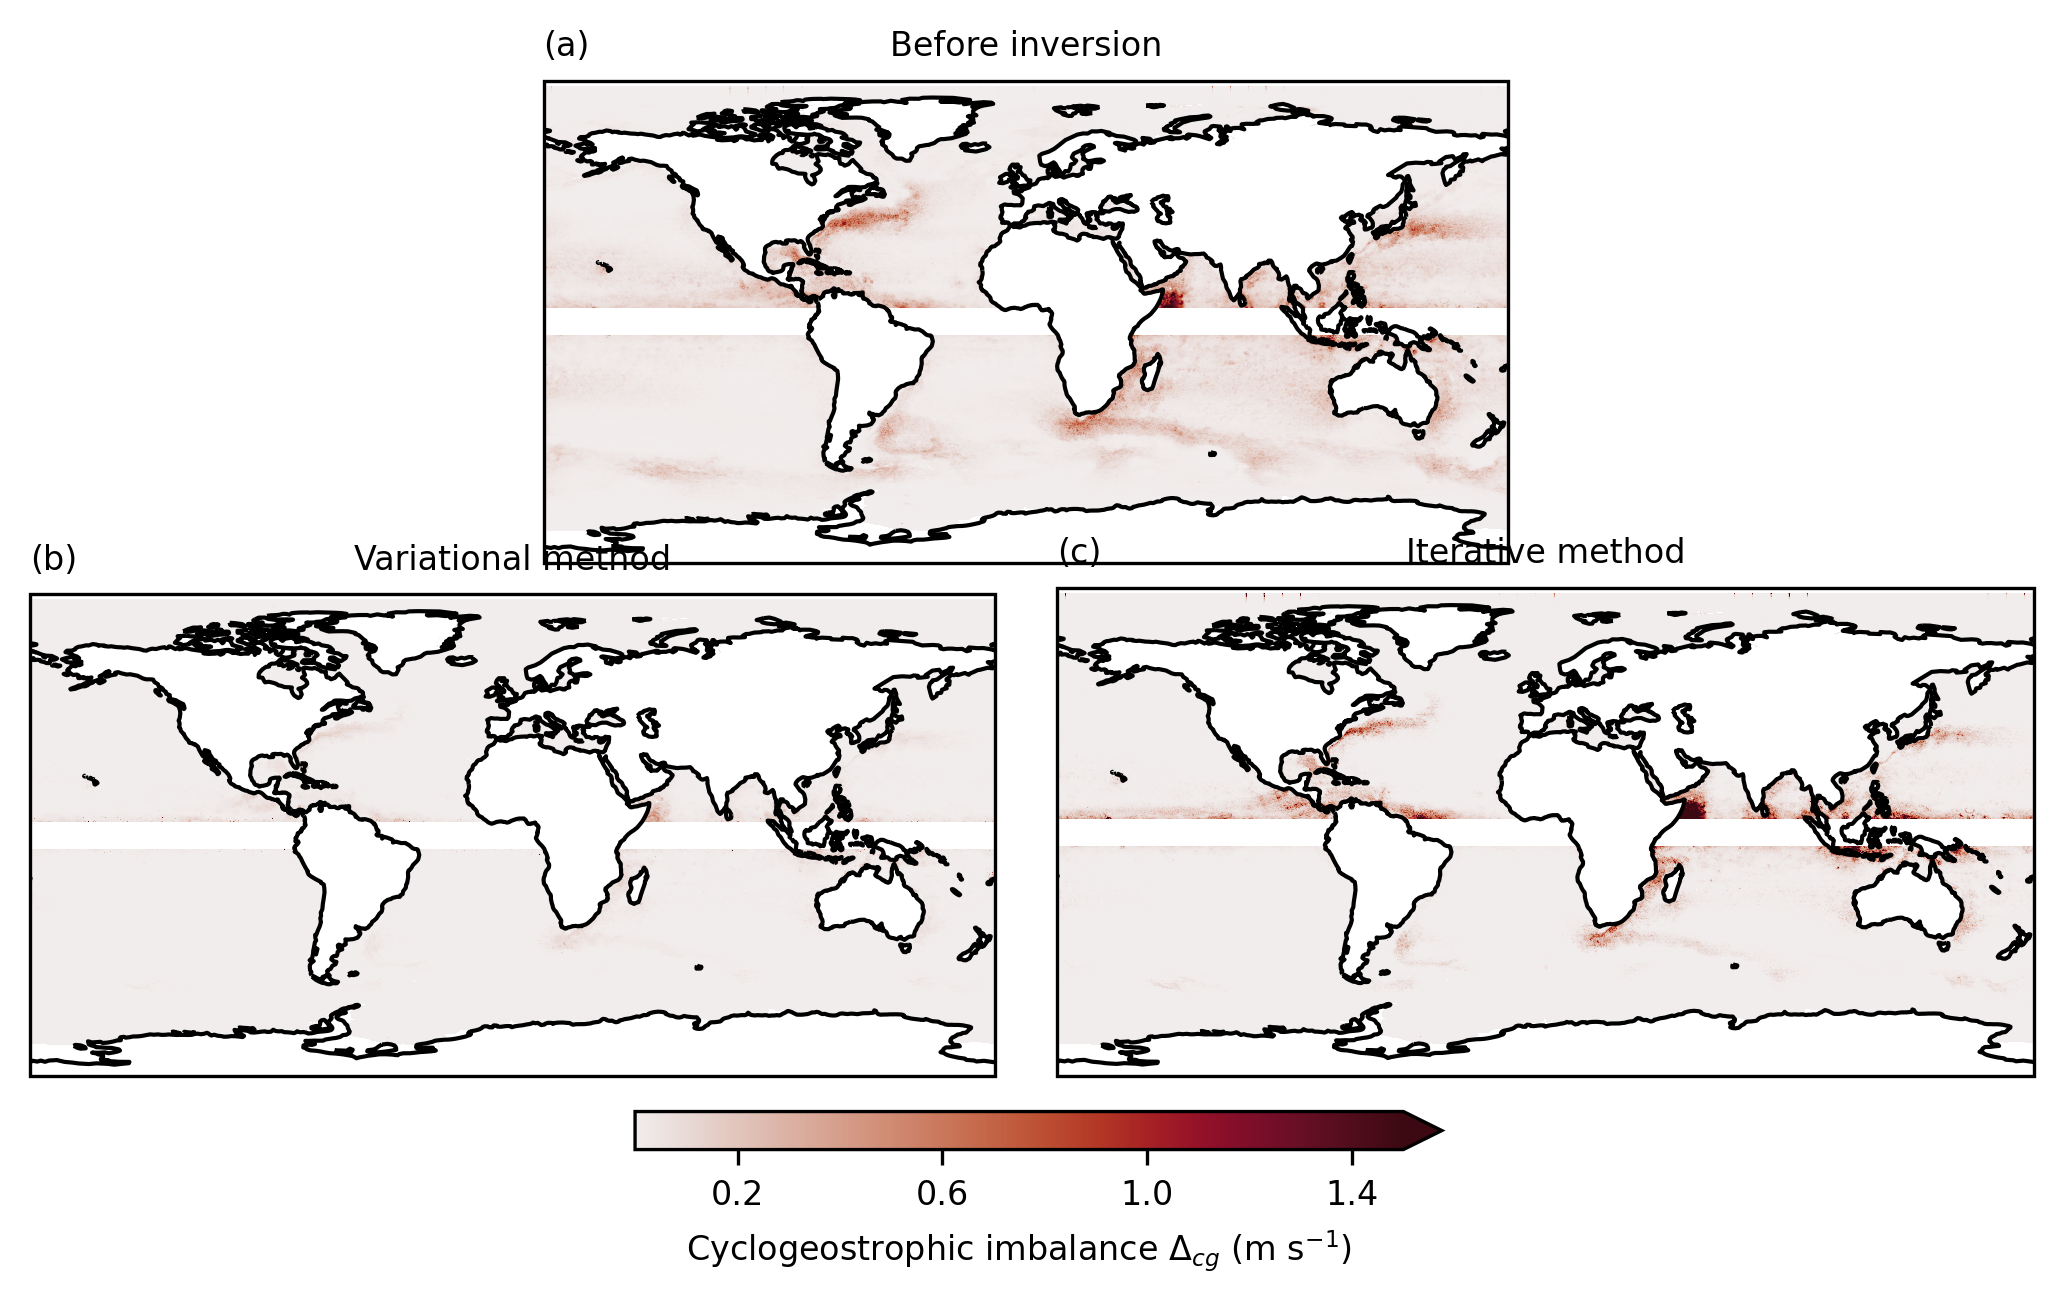

In [7]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) * n_rows + 
        HW_SPACE * (n_rows - 1) + CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    ..AAAA..
    BBBBCCCC
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = plot_uv_imbalance(
    duacs_imbalance_uv_Geostrophy.imbalance_uv_Geostrophy,
    duacs_imbalance_uv_Geostrophy.latitude, duacs_imbalance_uv_Geostrophy.longitude,
    "Before inversion", "(a)",
    axd["A"]
)

_ = plot_uv_imbalance(
    duacs_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy,
    duacs_imbalance_uv_Cyclogeostrophy.latitude, duacs_it_imbalance_uv_Cyclogeostrophy.longitude,
    "Variational method", "(b)",
    axd["B"]
)

_ = plot_uv_imbalance( 
    duacs_it_imbalance_uv_Cyclogeostrophy.imbalance_uv_Cyclogeostrophy,
    duacs_it_imbalance_uv_Cyclogeostrophy.latitude, duacs_it_imbalance_uv_Cyclogeostrophy.longitude,
    "Iterative method", "(c)",
    axd["C"]
)

clb = fig.colorbar(
    im, ax=axd.values(), 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.4), 
    extend="max"
)
clb.set_label(label="Cyclogeostrophic imbalance $\Delta_{cg}$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

# Snapshot - Figure 2

In [8]:
UV_MAX = 1.5
NRV_MAX = .5

## NeurOST - Iterative method

In [9]:
neurost_it_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_it_snapshot.nc")
neurost_it_snapshot_zoom = restrict_to_gulfstream(neurost_it_snapshot)

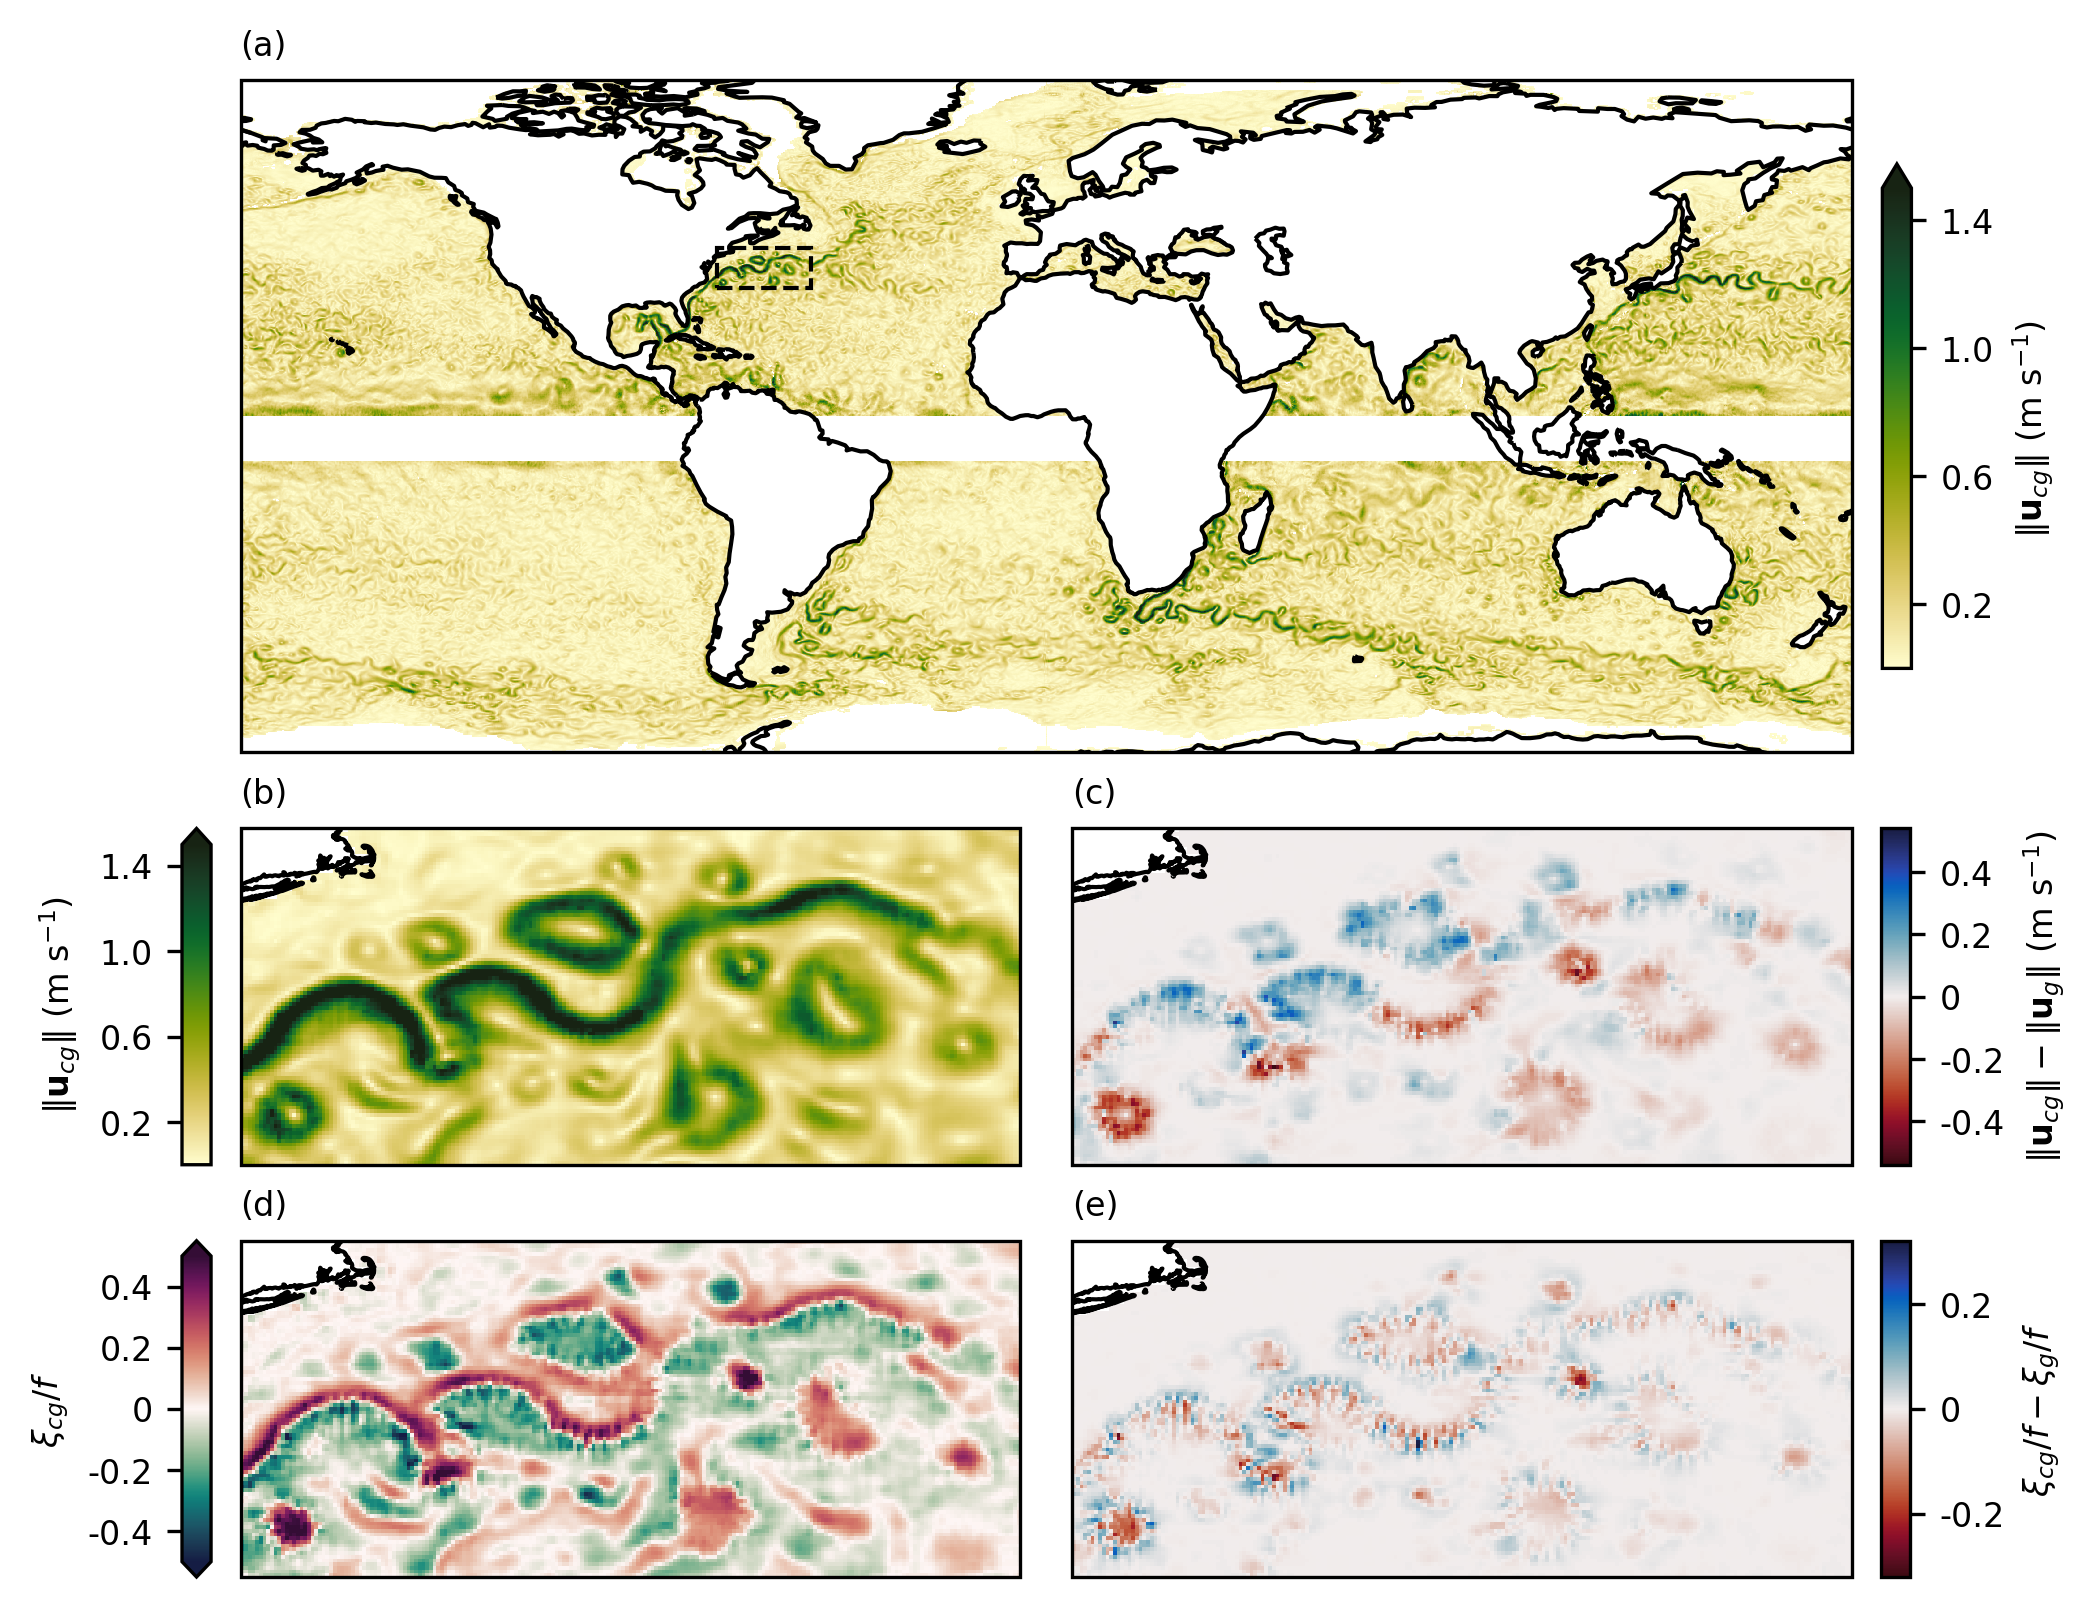

In [10]:
n_rows = 3
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - (CLB_AXIS_HW + CLB_HW_SPACE)) * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) +
        (
            (
                fig_width - HW_SPACE * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H)
            ) / n_cols * PLOT_GS_HW_RATIO + TITLE_H
        ) * (n_rows - 1) + 
        HW_SPACE * (n_rows - 1)
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AA
    BC
    DE
    """,
    height_ratios=[2, 1, 1],
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    neurost_it_snapshot.longitude, neurost_it_snapshot.latitude, 
    neurost_it_snapshot.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

axd["A"].add_patch(mpatches.Rectangle(
    xy=[neurost_it_snapshot_zoom.longitude.min(), neurost_it_snapshot_zoom.latitude.min()],
    width=neurost_it_snapshot_zoom.longitude.max() - neurost_it_snapshot_zoom.longitude.min(),
    height=neurost_it_snapshot_zoom.latitude.max() - neurost_it_snapshot_zoom.latitude.min(),
    linestyle="--", edgecolor="k", facecolor="none", linewidth=1
))

clb = fig.colorbar(
    im, ax=axd["A"],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="right", clb_shrink=.75), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["B"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, 
    neurost_it_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

uv_diff = neurost_it_snapshot_zoom.magn_Cyclogeostrophy - neurost_it_snapshot_zoom.magn_Geostrophy
uv_diff_max = np.nanmax(np.abs(uv_diff))
im = axd["C"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, uv_diff,
    cmap=cmo.balance_r, vmin=-uv_diff_max, vmax=uv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["C"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_{cg} \| - \| \mathbf{u}_g \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["D"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, 
    neurost_it_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["D"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="both"
)
clb.set_label(label="$\\xi_{cg}/f$", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

nrv_diff = neurost_it_snapshot_zoom.nrv_Cyclogeostrophy - neurost_it_snapshot_zoom.nrv_Geostrophy
nrv_diff_max = np.nanmax(np.abs(nrv_diff))
im = axd["E"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, nrv_diff,
    cmap=cmo.balance_r, vmin=-nrv_diff_max, vmax=nrv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["E"].coastlines()
axd["E"].set_title("(e)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["E"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\\xi_{cg}/f - \\xi_g/f$", size=FONT_SIZE)
tick_labels = [-0.2 , 0, 0.2]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

## DUACS

In [11]:
duacs_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_snapshot.nc")
duacs_snapshot_zoom = restrict_to_gulfstream(duacs_snapshot)

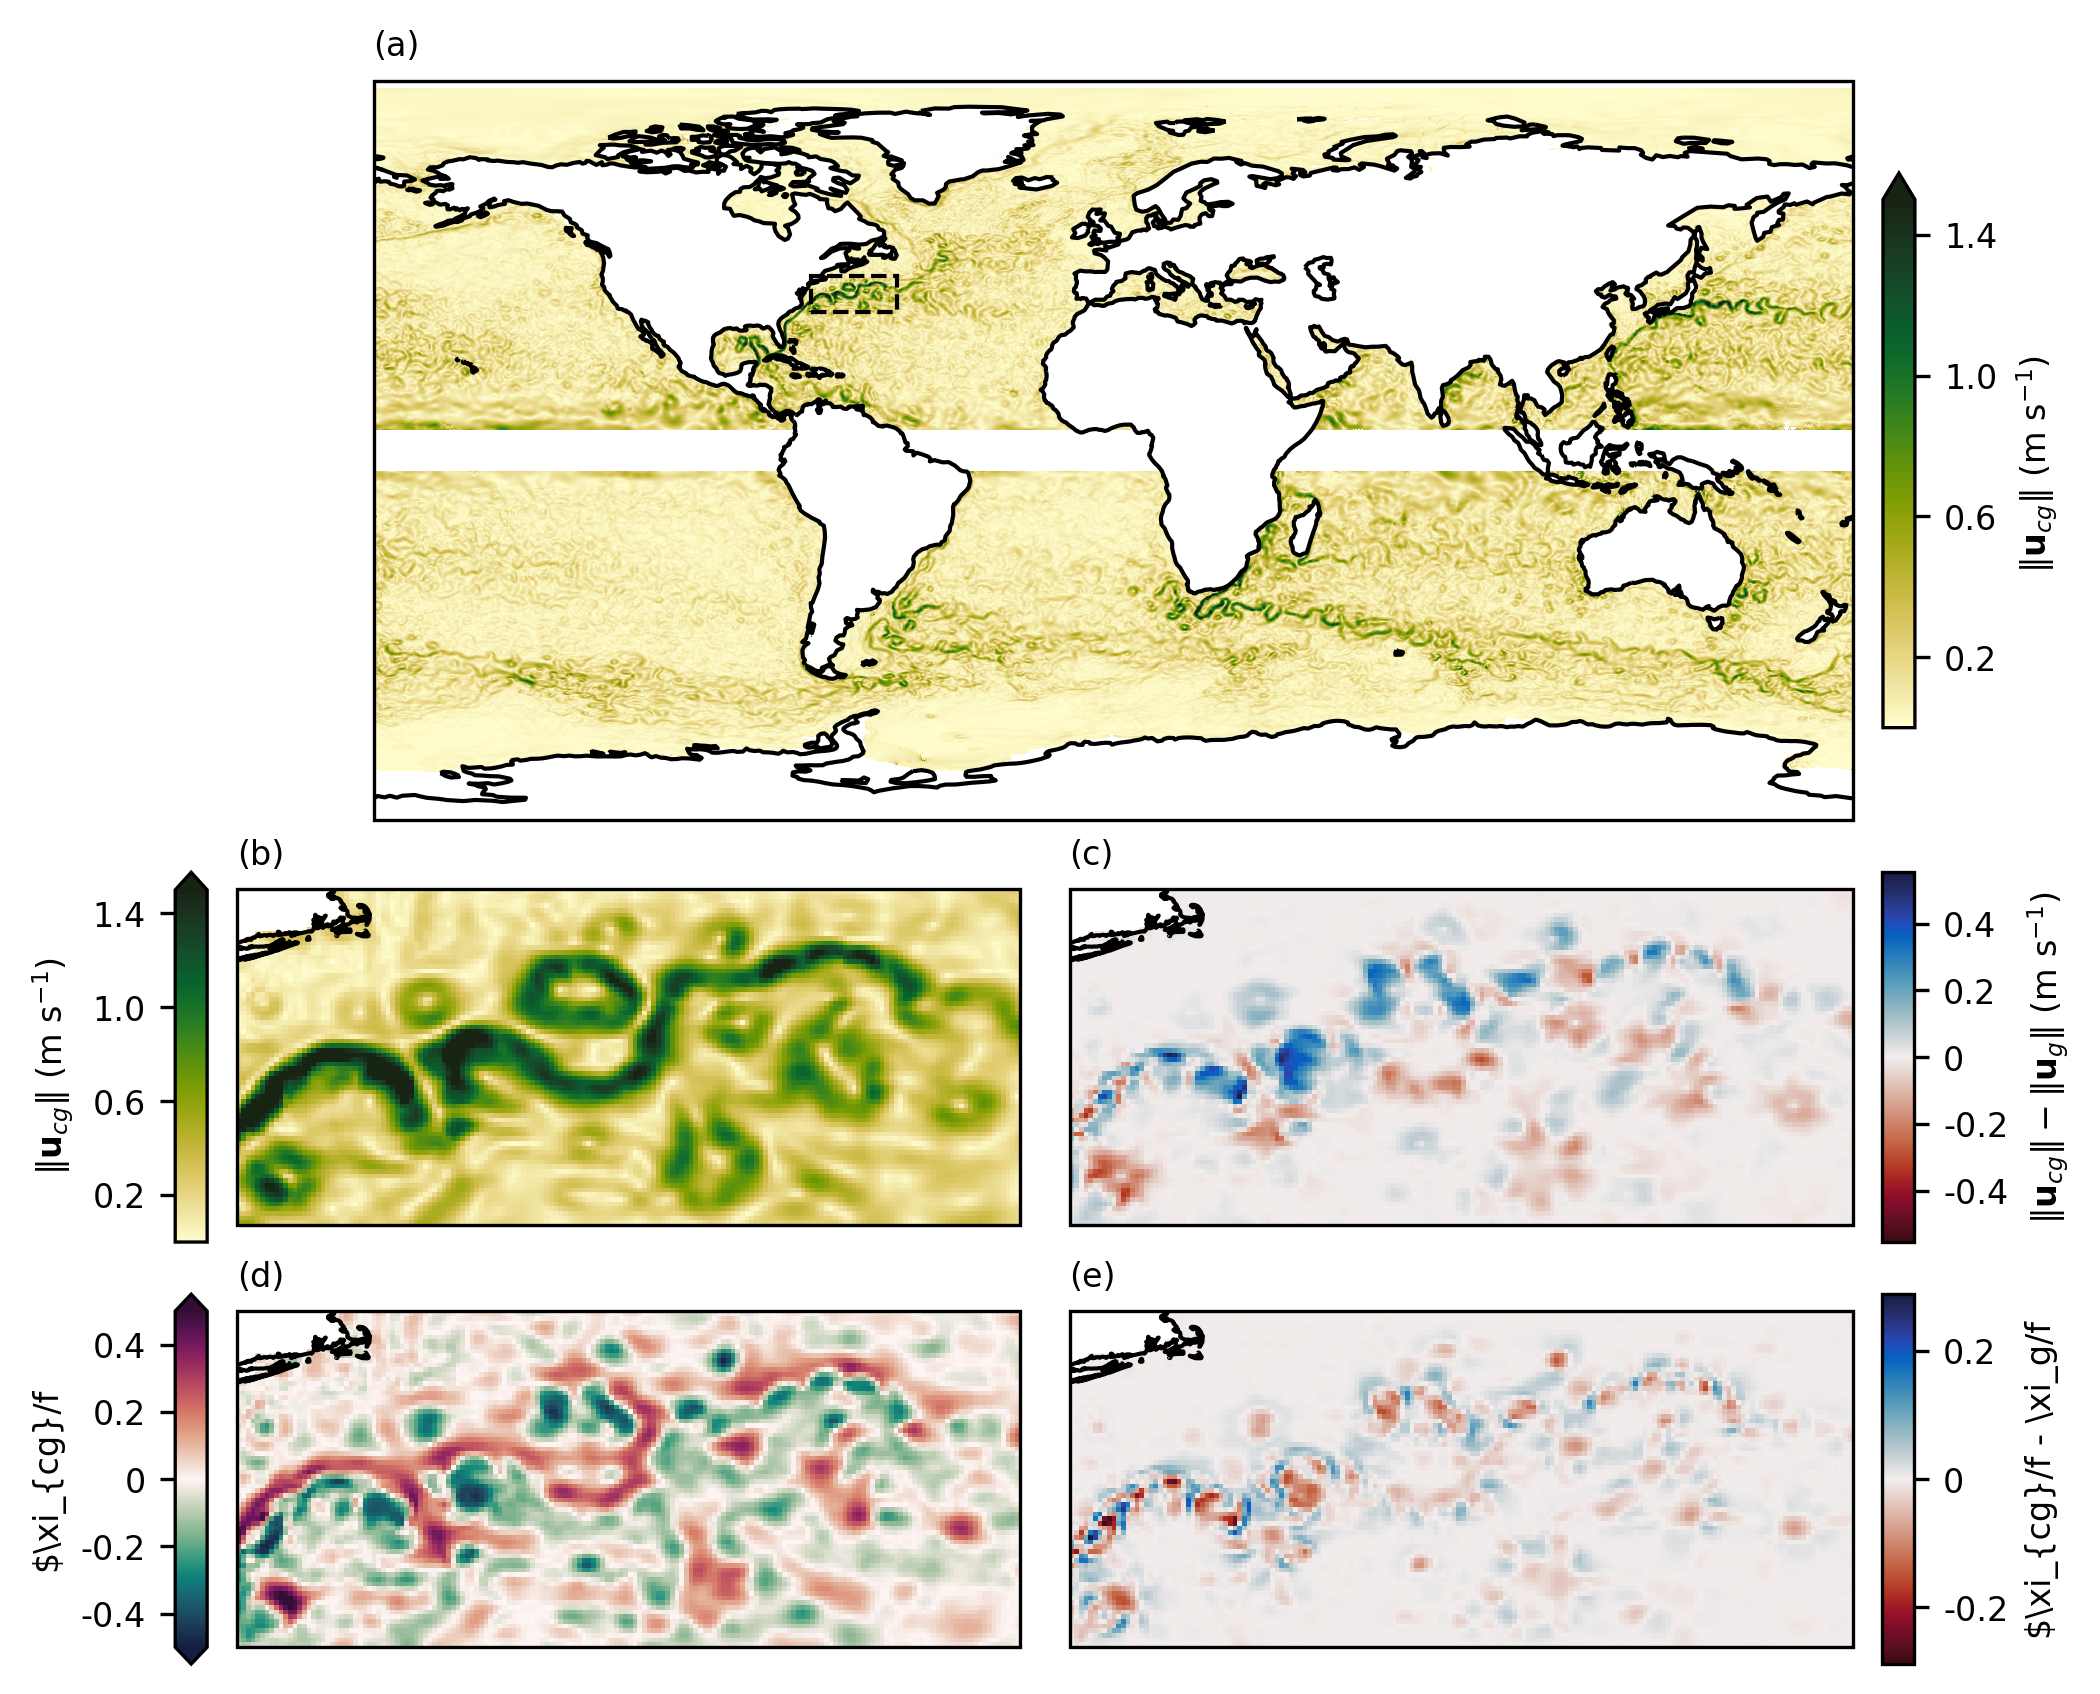

In [12]:
n_rows = 3
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - (CLB_AXIS_HW + CLB_HW_SPACE)) * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) +
        (
            (
                fig_width - HW_SPACE * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H)
            ) / n_cols * PLOT_GS_HW_RATIO + TITLE_H
        ) * (n_rows - 1) + 
        HW_SPACE * (n_rows - 1)
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AA
    BC
    DE
    """,
    height_ratios=[2, 1, 1],
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    duacs_snapshot.longitude, duacs_snapshot.latitude, 
    duacs_snapshot.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

axd["A"].add_patch(mpatches.Rectangle(
    xy=[duacs_snapshot_zoom.longitude.min(), duacs_snapshot_zoom.latitude.min()],
    width=duacs_snapshot_zoom.longitude.max() - duacs_snapshot_zoom.longitude.min(),
    height=duacs_snapshot_zoom.latitude.max() - duacs_snapshot_zoom.latitude.min(),
    linestyle="--", edgecolor="k", facecolor="none", linewidth=1
))

clb = fig.colorbar(
    im, ax=axd["A"],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="right", clb_shrink=.75), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["B"].pcolormesh(
    duacs_snapshot_zoom.longitude, duacs_snapshot_zoom.latitude, 
    duacs_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

uv_diff = duacs_snapshot_zoom.magn_Cyclogeostrophy - duacs_snapshot_zoom.magn_Geostrophy
uv_diff_max = np.nanmax(np.abs(uv_diff))
im = axd["C"].pcolormesh(
    duacs_snapshot_zoom.longitude, duacs_snapshot_zoom.latitude, uv_diff,
    cmap=cmo.balance_r, vmin=-uv_diff_max, vmax=uv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["C"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_{cg} \| - \| \mathbf{u}_g \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["D"].pcolormesh(
    duacs_snapshot_zoom.longitude, duacs_snapshot_zoom.latitude, 
    duacs_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["D"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="both"
)
clb.set_label(label="$\\xi_{cg}/f", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

nrv_diff = duacs_snapshot_zoom.nrv_Cyclogeostrophy - duacs_snapshot_zoom.nrv_Geostrophy
nrv_diff_max = np.nanmax(np.abs(nrv_diff))
im = axd["E"].pcolormesh(
    duacs_snapshot_zoom.longitude, duacs_snapshot_zoom.latitude, nrv_diff,
    cmap=cmo.balance_r, vmin=-nrv_diff_max, vmax=nrv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["E"].coastlines()
axd["E"].set_title("(e)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["E"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\\xi_{cg}/f - \\xi_g/f", size=FONT_SIZE)
tick_labels = [-0.2 , 0, 0.2]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

## DUACS - Iterative method

In [13]:
duacs_it_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/duacs_it_snapshot.nc")
duacs_it_snapshot_zoom = restrict_to_gulfstream(duacs_snapshot)

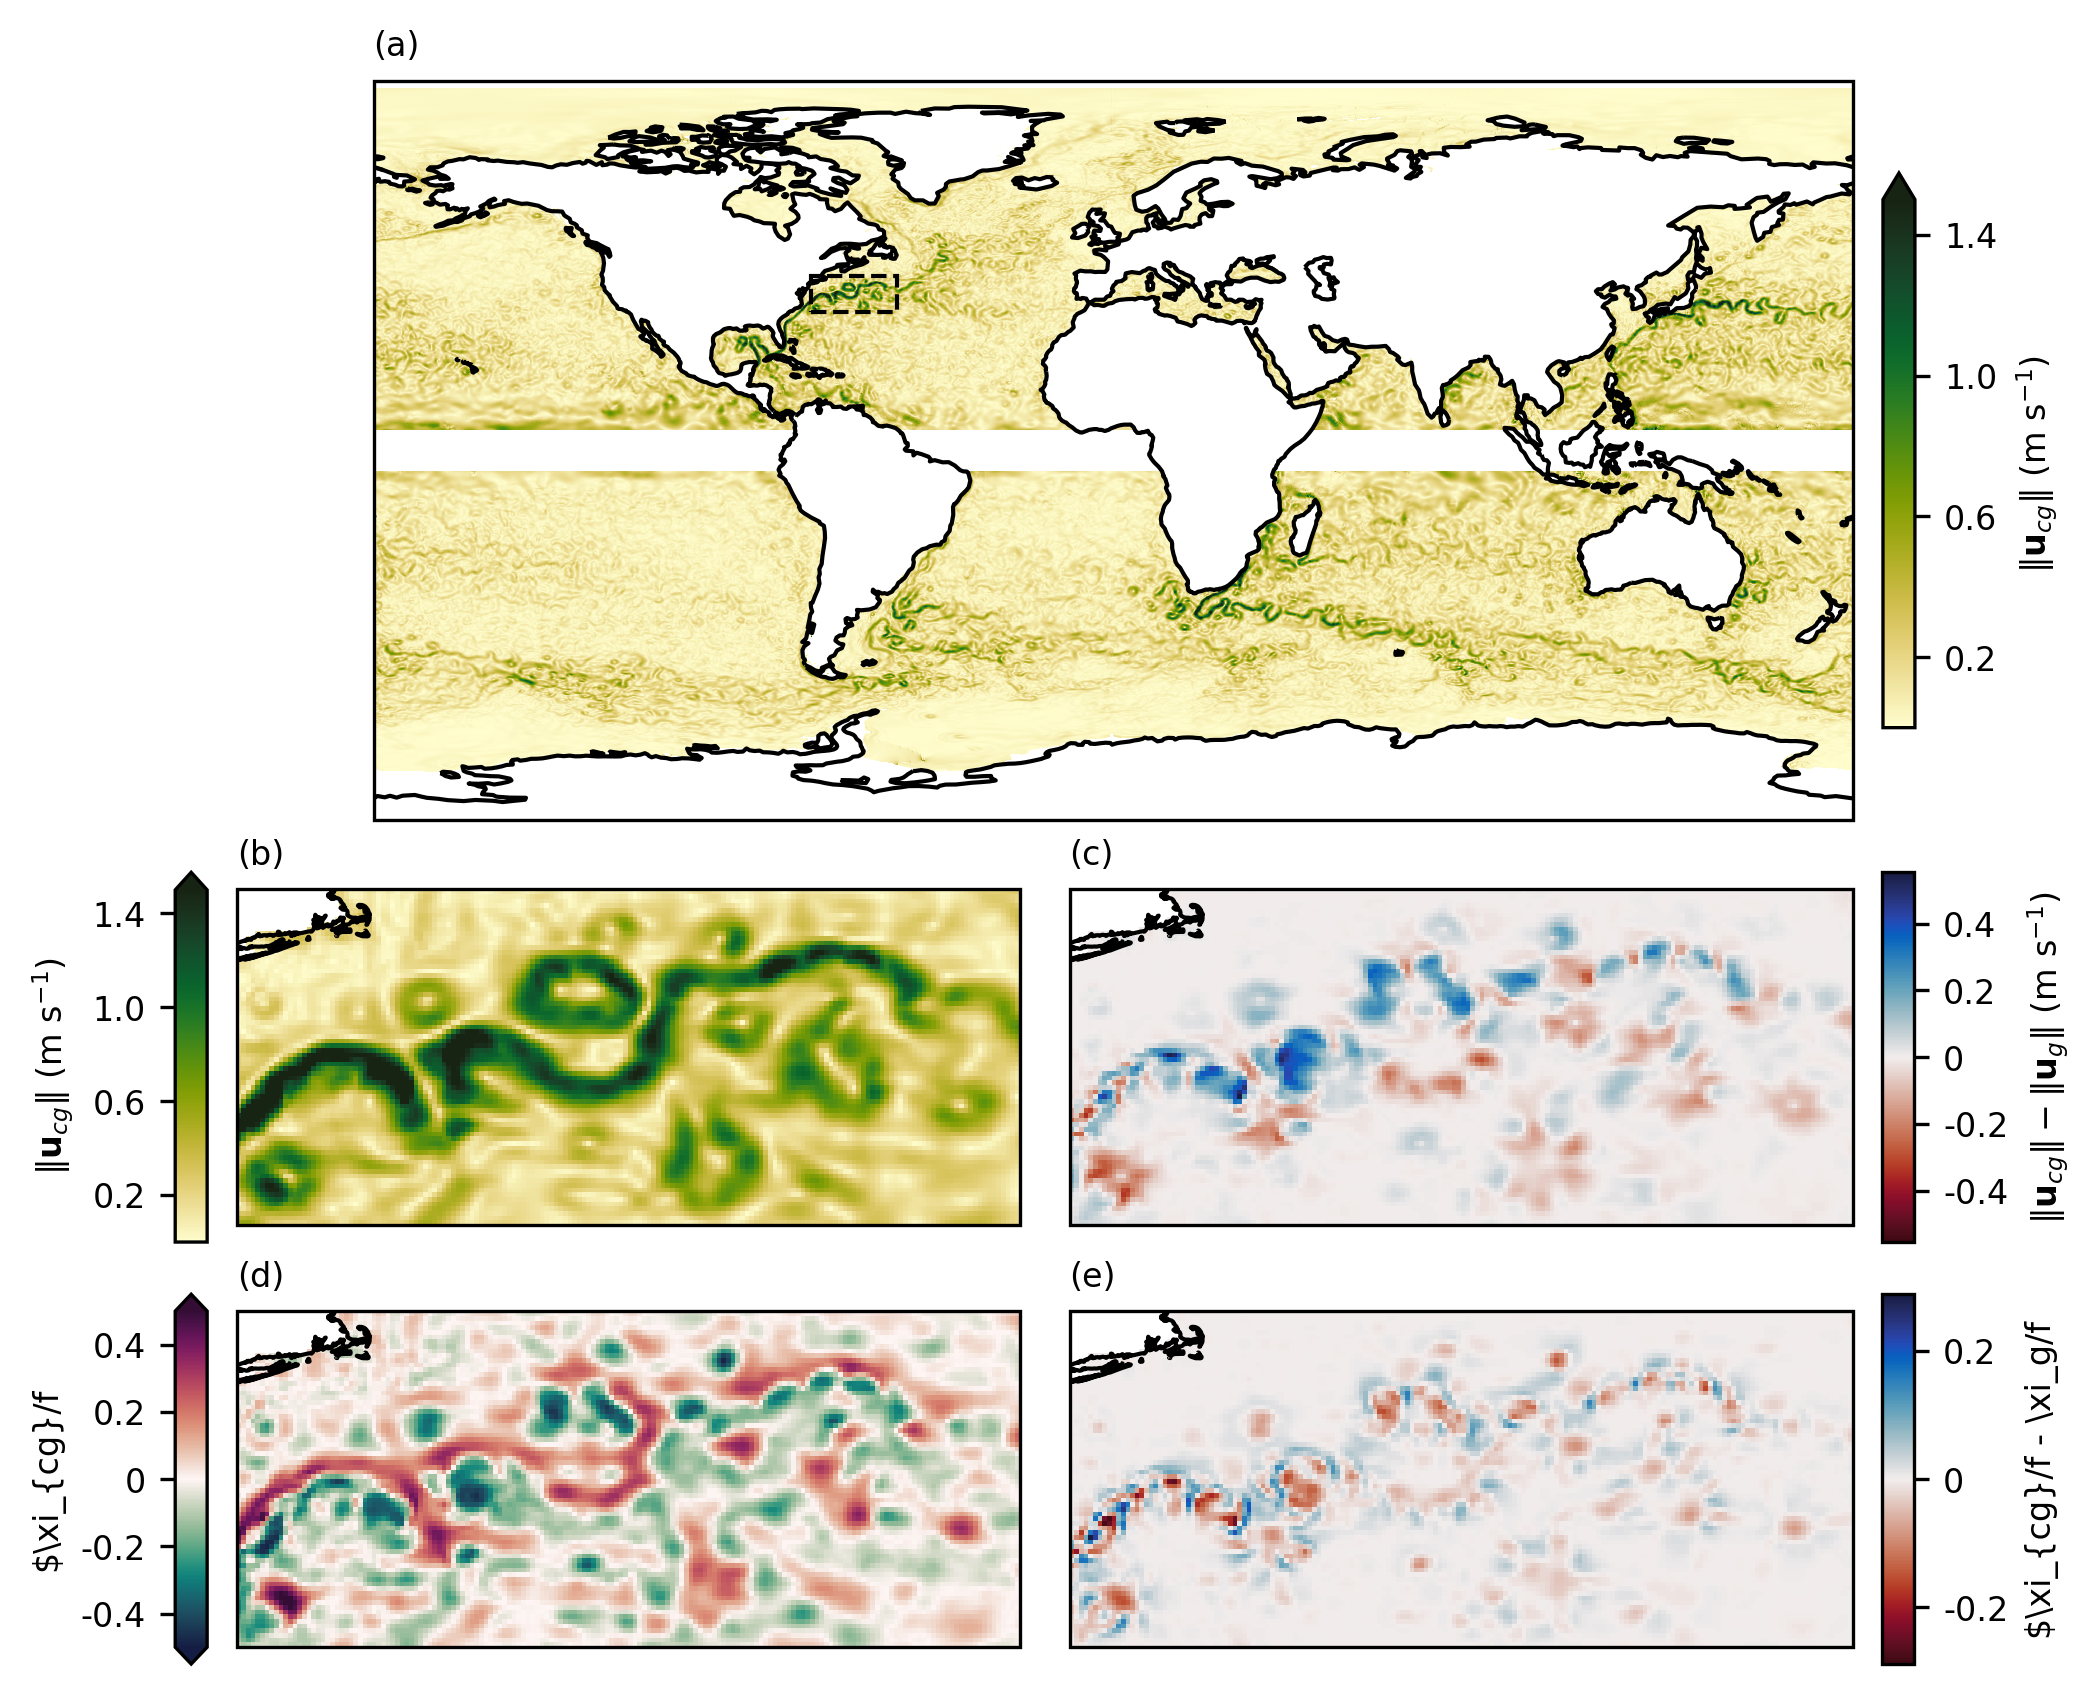

In [14]:
n_rows = 3
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    (
        ((fig_width - (CLB_AXIS_HW + CLB_HW_SPACE)) * PLOT_NEUROST_GLOBAL_HW_RATIO + TITLE_H) +
        (
            (
                fig_width - HW_SPACE * (n_cols - 1) - (CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H)
            ) / n_cols * PLOT_GS_HW_RATIO + TITLE_H
        ) * (n_rows - 1) + 
        HW_SPACE * (n_rows - 1)
    ),
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AA
    BC
    DE
    """,
    height_ratios=[2, 1, 1],
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    duacs_it_snapshot.longitude, duacs_it_snapshot.latitude, 
    duacs_it_snapshot.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)

axd["A"].add_patch(mpatches.Rectangle(
    xy=[duacs_it_snapshot_zoom.longitude.min(), duacs_it_snapshot_zoom.latitude.min()],
    width=duacs_it_snapshot_zoom.longitude.max() - duacs_it_snapshot_zoom.longitude.min(),
    height=duacs_it_snapshot_zoom.latitude.max() - duacs_it_snapshot_zoom.latitude.min(),
    linestyle="--", edgecolor="k", facecolor="none", linewidth=1
))

clb = fig.colorbar(
    im, ax=axd["A"],
    **get_clb_kwargs(fig_width, fig_height / 2, clb_location="right", clb_shrink=.75), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["B"].pcolormesh(
    duacs_it_snapshot_zoom.longitude, duacs_it_snapshot_zoom.latitude, 
    duacs_it_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["B"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

uv_diff = duacs_it_snapshot_zoom.magn_Cyclogeostrophy - duacs_it_snapshot_zoom.magn_Geostrophy
uv_diff_max = np.nanmax(np.abs(uv_diff))
im = axd["C"].pcolormesh(
    duacs_it_snapshot_zoom.longitude, duacs_it_snapshot_zoom.latitude, uv_diff,
    cmap=cmo.balance_r, vmin=-uv_diff_max, vmax=uv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["C"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\| \mathbf{u}_{cg} \| - \| \mathbf{u}_g \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

im = axd["D"].pcolormesh(
    duacs_it_snapshot_zoom.longitude, duacs_it_snapshot_zoom.latitude, 
    duacs_it_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["D"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="left", clb_shrink=1), 
    extend="both"
)
clb.set_label(label="$\\xi_{cg}/f", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

nrv_diff = duacs_it_snapshot_zoom.nrv_Cyclogeostrophy - duacs_it_snapshot_zoom.nrv_Geostrophy
nrv_diff_max = np.nanmax(np.abs(nrv_diff))
im = axd["E"].pcolormesh(
    duacs_it_snapshot_zoom.longitude, duacs_it_snapshot_zoom.latitude, nrv_diff,
    cmap=cmo.balance_r, vmin=-nrv_diff_max, vmax=nrv_diff_max,
    transform=ccrs.PlateCarree()
)
axd["E"].coastlines()
axd["E"].set_title("(e)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd["E"],
    **get_clb_kwargs(fig_width / 2, fig_height / 4, clb_location="right", clb_shrink=1)
)
clb.set_label(label="$\\xi_{cg}/f - \\xi_g/f", size=FONT_SIZE)
tick_labels = [-0.2 , 0, 0.2]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

## Variational vs. Iterative method

In [15]:
neurost_snapshot = xr.open_dataset(f"{DATA_FILES_PATH}/neurost_snapshot.nc")
neurost_snapshot_zoom = restrict_to_gulfstream(neurost_snapshot)

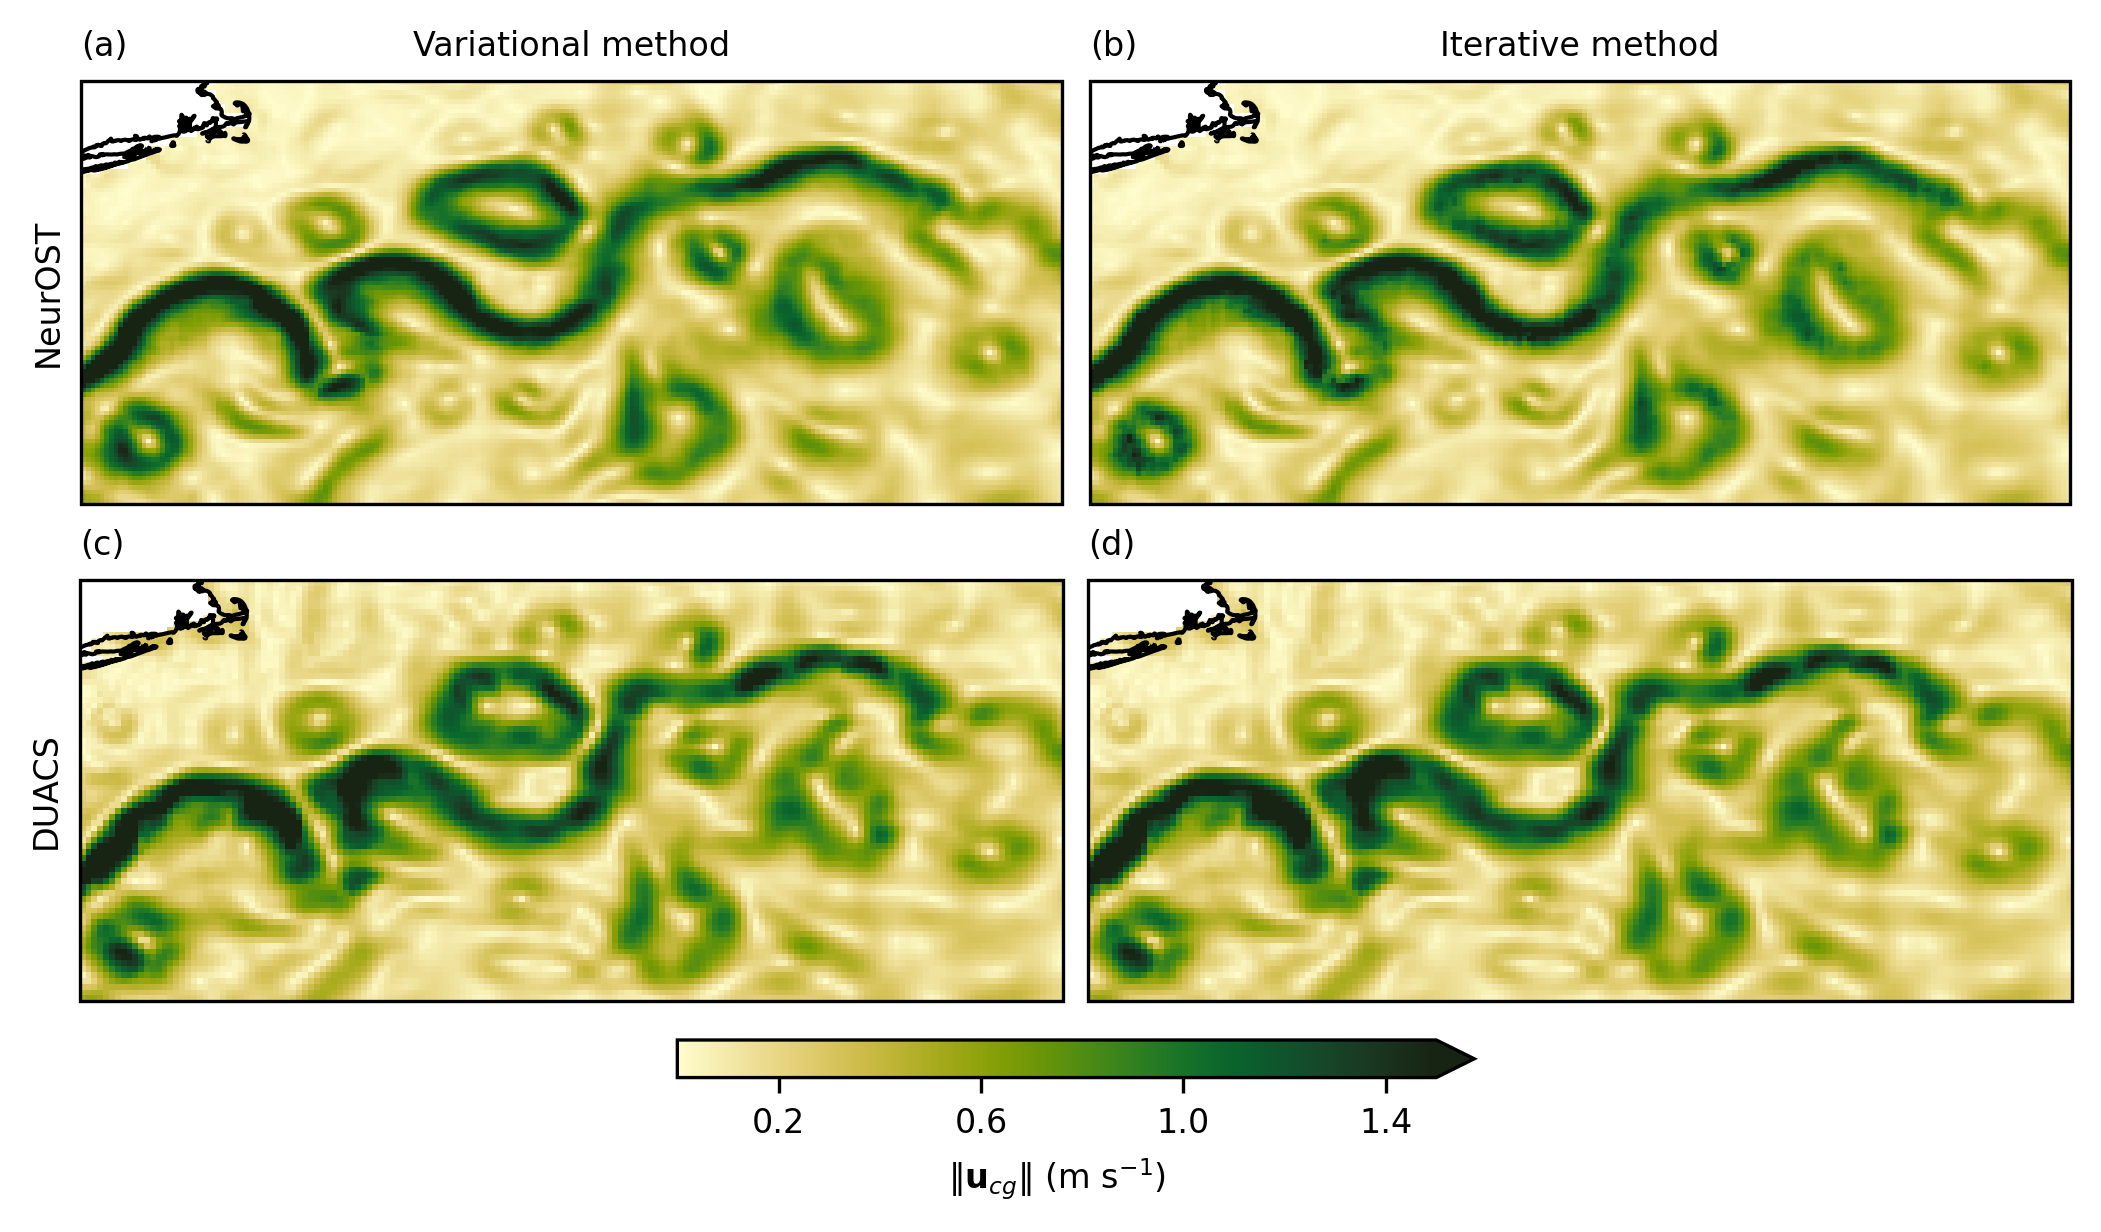

In [16]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_GS_HW_RATIO + TITLE_H) * n_rows + 
    HW_SPACE * (n_rows - 1) + CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H
    ,
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, 
    neurost_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)
axd["A"].set_title("Variational method", fontsize=FONT_SIZE)
axd["A"].set_ylabel("NeurOST", fontsize=FONT_SIZE)
axd["A"].set_yticks([])

im = axd["B"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, 
    neurost_it_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)
axd["B"].set_title("Iterative method", fontsize=FONT_SIZE)

im = axd["C"].pcolormesh(
    duacs_snapshot_zoom.longitude, duacs_snapshot_zoom.latitude, 
    duacs_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)
axd["C"].set_ylabel("DUACS", fontsize=FONT_SIZE)
axd["C"].set_yticks([])

im = axd["D"].pcolormesh(
    duacs_it_snapshot_zoom.longitude, duacs_it_snapshot_zoom.latitude, 
    duacs_it_snapshot_zoom.magn_Cyclogeostrophy,
    cmap=cmo.speed, vmin=0, vmax=UV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd.values(),
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.4), 
    extend="max"
)
clb.set_label(label="$\| \mathbf{u}_{cg} \|$ (m s$^{-1}$)", size=FONT_SIZE)
tick_labels = [0.2, 0.6 , 1.0, 1.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

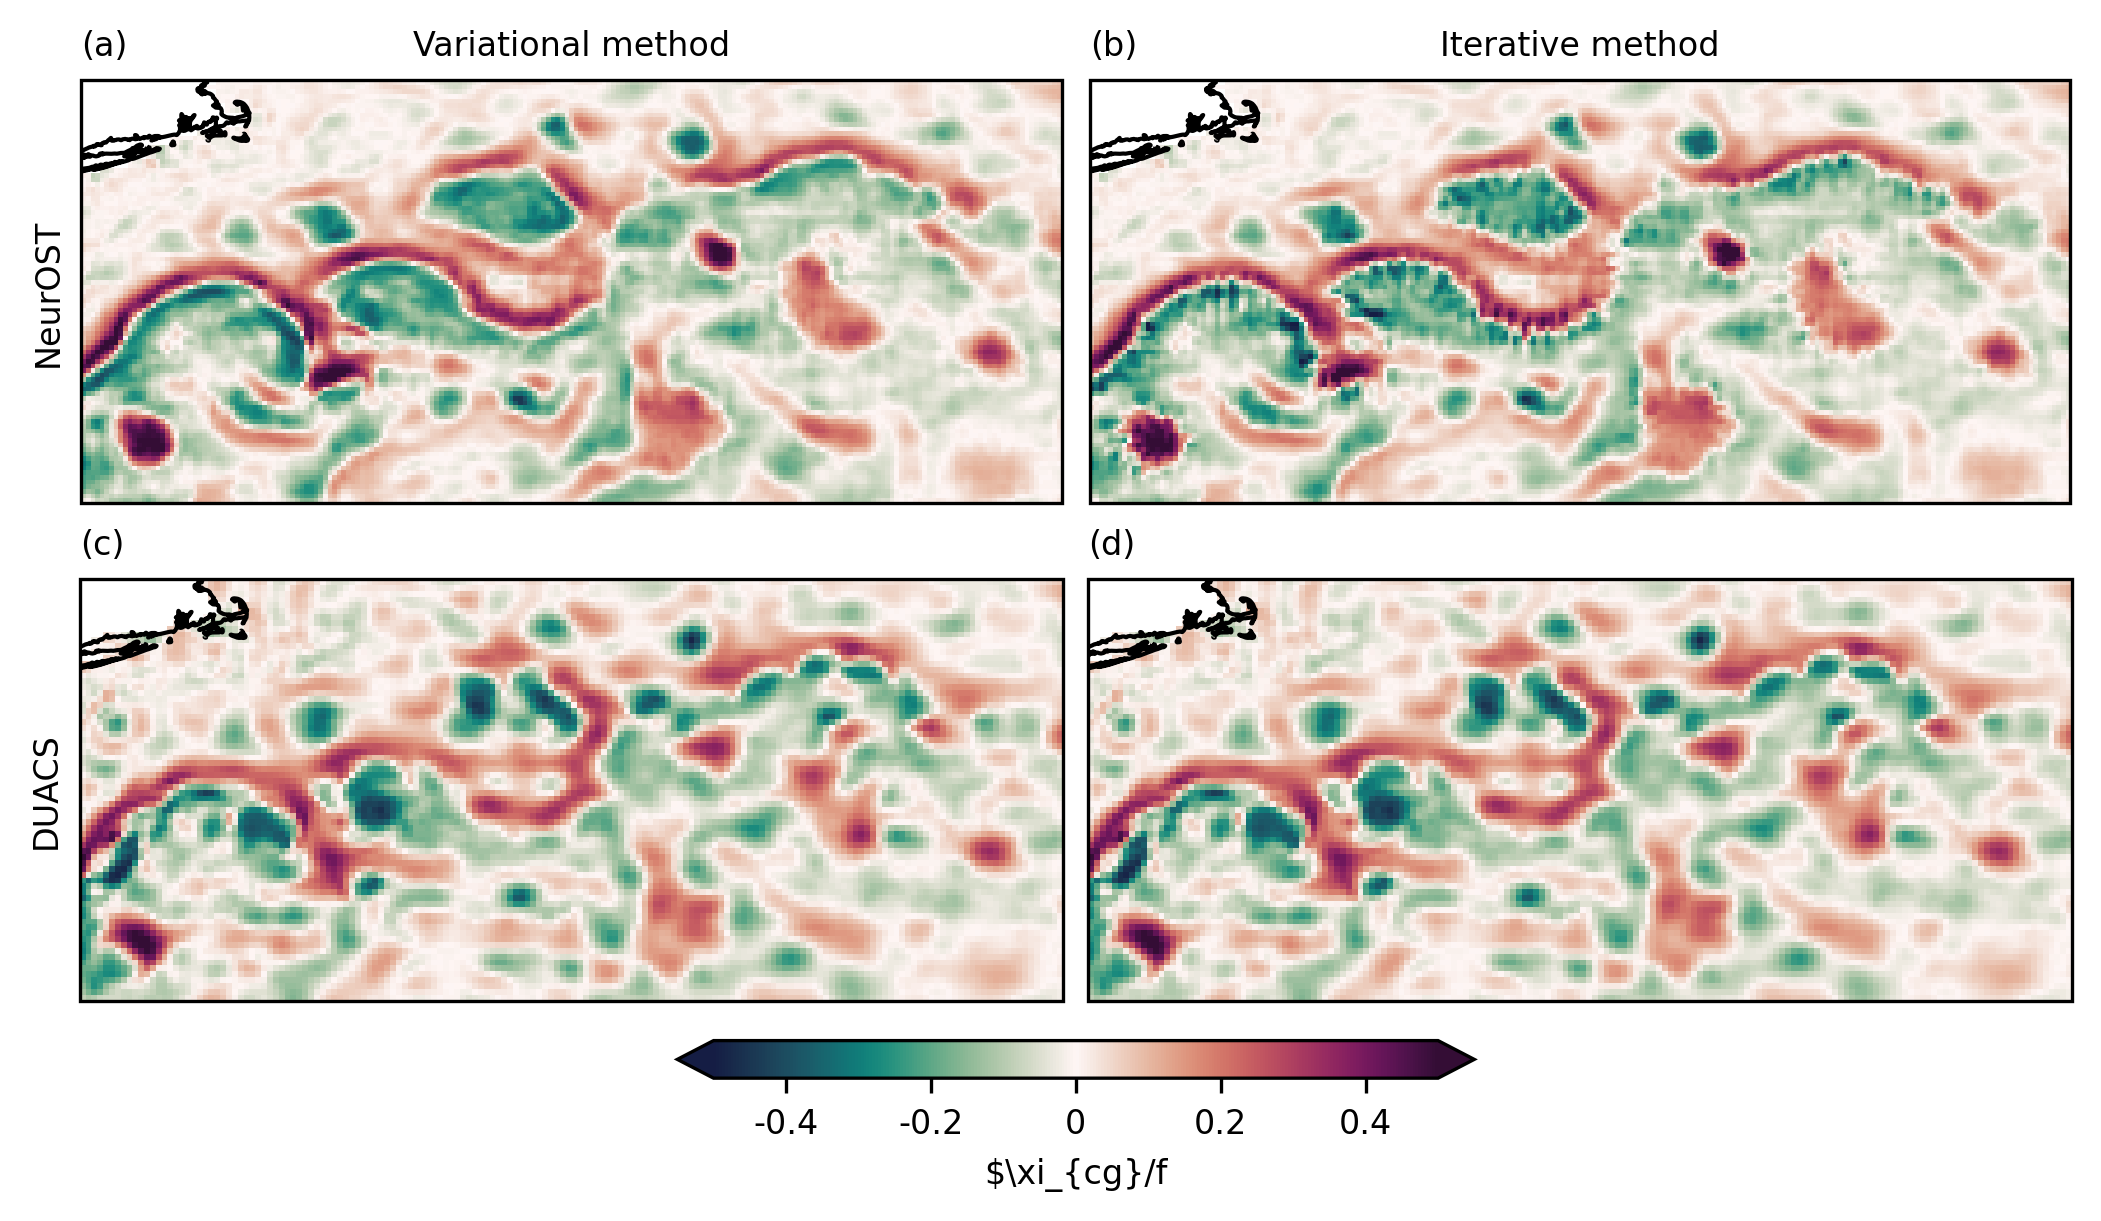

In [17]:
n_rows = 2
n_cols = 2
fig_width = MAX_WIDTH
fig_height = min(
    ((fig_width - HW_SPACE * (n_cols - 1)) / n_cols * PLOT_GS_HW_RATIO + TITLE_H) * n_rows + 
    HW_SPACE * (n_rows - 1) + CLB_AXIS_HW + CLB_HW_SPACE + TITLE_H
    ,
    MAX_HEIGHT
)

fig, axd = plt.subplot_mosaic(
    """
    AB
    CD
    """,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
    gridspec_kw=get_gridspec_kwargs(fig_width, fig_height),
    figsize=(fig_width, fig_height), dpi=DPI, layout="compressed"
)

im = axd["A"].pcolormesh(
    neurost_snapshot_zoom.longitude, neurost_snapshot_zoom.latitude, 
    neurost_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["A"].coastlines()
axd["A"].set_title("(a)", loc="left", fontsize=FONT_SIZE)
axd["A"].set_title("Variational method", fontsize=FONT_SIZE)
axd["A"].set_ylabel("NeurOST", fontsize=FONT_SIZE)
axd["A"].set_yticks([])

im = axd["B"].pcolormesh(
    neurost_it_snapshot_zoom.longitude, neurost_it_snapshot_zoom.latitude, 
    neurost_it_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["B"].coastlines()
axd["B"].set_title("(b)", loc="left", fontsize=FONT_SIZE)
axd["B"].set_title("Iterative method", fontsize=FONT_SIZE)

im = axd["C"].pcolormesh(
    duacs_snapshot_zoom.longitude, duacs_snapshot_zoom.latitude, 
    duacs_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["C"].coastlines()
axd["C"].set_title("(c)", loc="left", fontsize=FONT_SIZE)
axd["C"].set_ylabel("DUACS", fontsize=FONT_SIZE)
axd["C"].set_yticks([])

im = axd["D"].pcolormesh(
    duacs_it_snapshot_zoom.longitude, duacs_it_snapshot_zoom.latitude, 
    duacs_it_snapshot_zoom.nrv_Cyclogeostrophy,
    cmap=cmo.curl, vmin=-NRV_MAX, vmax=NRV_MAX,
    transform=ccrs.PlateCarree()
)
axd["D"].coastlines()
axd["D"].set_title("(d)", loc="left", fontsize=FONT_SIZE)

clb = fig.colorbar(
    im, ax=axd.values(),
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.4), 
    extend="both"
)
clb.set_label(label="$\\xi_{cg}/f", size=FONT_SIZE)
tick_labels = [-0.4, -0.2 , 0, 0.2, 0.4]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

# EKE gain / loss - Figure 3

In [18]:
EKE_DIFF_REL_MAX = 20

## NeurOST - Iterative method

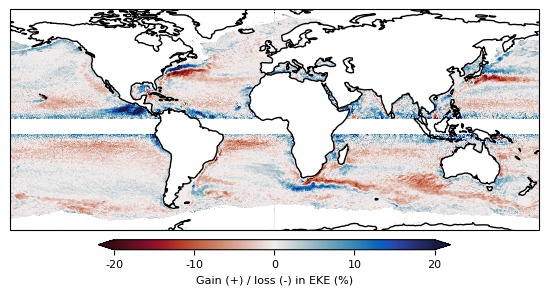

In [19]:
neurost_it_eke_diff_rel_Cyclogeostrophy_Geostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/neurost_it_eke_diff_rel_Cyclogeostrophy_Geostrophy.nc"
)

fig_width = MAX_WIDTH
fig_height = min(fig_width * PLOT_NEUROST_GLOBAL_HW_RATIO + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(fig_width, fig_height))

im = ax.pcolormesh(
    neurost_it_eke_diff_rel_Cyclogeostrophy_Geostrophy.longitude, 
    neurost_it_eke_diff_rel_Cyclogeostrophy_Geostrophy.latitude, 
    neurost_it_eke_diff_rel_Cyclogeostrophy_Geostrophy.eke_diff_rel_Cyclogeostrophy_Geostrophy,
    cmap=cmo.balance_r, vmin=-EKE_DIFF_REL_MAX, vmax=EKE_DIFF_REL_MAX,
    transform=ccrs.PlateCarree()
)
ax.coastlines()

clb = fig.colorbar(
    im, ax=ax, 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.66), 
    extend="both"
)
clb.set_label(label="Gain (+) / loss (-) in EKE (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

## DUACS

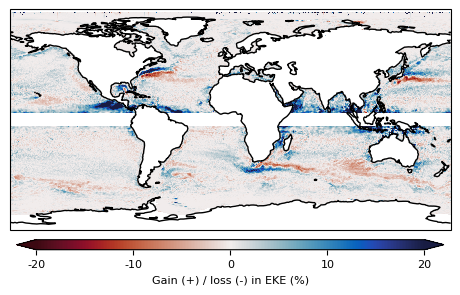

In [ ]:
duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy.nc"
)

fig_width = MAX_WIDTH
fig_height = min(fig_width * PLOT_NEUROST_GLOBAL_HW_RATIO + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(fig_width, fig_height))

im = ax.pcolormesh(
    duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy.longitude, duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy.latitude, 
    duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy.__xarray_dataarray_variable__,
    cmap=cmo.balance_r, vmin=-EKE_DIFF_REL_MAX, vmax=EKE_DIFF_REL_MAX,
    transform=ccrs.PlateCarree()
)
ax.coastlines()

clb = fig.colorbar(
    im, ax=ax, 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.8), 
    extend="both"
)
clb.set_label(label="Gain (+) / loss (-) in EKE (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()

## DUACS - Iterative method

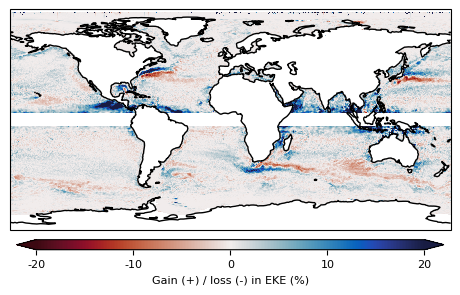

In [26]:
duacs_it_eke_diff_rel_Cyclogeostrophy_Geostrophy = xr.open_dataset(
    f"{DATA_FILES_PATH}/duacs_it_eke_diff_rel_Cyclogeostrophy_Geostrophy.nc"
)

fig_width = MAX_WIDTH
fig_height = min(fig_width * PLOT_NEUROST_GLOBAL_HW_RATIO + CLB_AXIS_HW + CLB_HW_SPACE, MAX_HEIGHT)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(fig_width, fig_height))

im = ax.pcolormesh(
    duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy.longitude, duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy.latitude, 
    duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy.__xarray_dataarray_variable__,
    cmap=cmo.balance_r, vmin=-EKE_DIFF_REL_MAX, vmax=EKE_DIFF_REL_MAX,
    transform=ccrs.PlateCarree()
)
ax.coastlines()

clb = fig.colorbar(
    im, ax=ax, 
    **get_clb_kwargs(fig_width, fig_height, clb_location="bottom", clb_shrink=.8), 
    extend="both"
)
clb.set_label(label="Gain (+) / loss (-) in EKE (%)", size=FONT_SIZE)
tick_labels = [-20, -10, 0, 10, 20]
clb.set_ticks(tick_labels)
clb.set_ticklabels(tick_labels, fontsize=FONT_SIZE)

plt.show()